In [26]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
import time

from ctisim.utils import ITL_AMP_GEOM
from ctisim.image import SegmentSimulator
from ctisim.core import LinearTrap, LogisticTrap, FloatingOutputAmplifier, BaseOutputAmplifier
from ctisim.matrix import cti_operator, one_trap_operator, two_trap_operator

## Testing on Simulations

In [32]:
cti = 1.E-6

#output_amplifier = BaseOutputAmplifier(1.0, noise=6.5/np.sqrt(2000.))
output_amplifier = FloatingOutputAmplifier(1.0, 0.0002289994239807129, 2.434251, noise=6.5/np.sqrt(2000.))

trap1 = LinearTrap(4.0, 0.4, 1, 0.08)
trap2 = LogisticTrap(4.0, 0.4, 1, 12500., 0.002)

signals = np.logspace(2, np.log10(150000.), ITL_AMP_GEOM.ny)

segment = SegmentSimulator.from_amp_geom(ITL_AMP_GEOM, output_amplifier, cti=cti, traps=[trap1])
segment.ramp_exp(signals)

segarr = segment.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, parallel_overscan_width=0)

ny, nx = segarr.shape

In [59]:
## Correct with matrix
D_cti = cti_operator(cti, nx)
Dinv_cti = inv(D_cti)

corrected2 = np.zeros(segarr.shape)
corrected3 = np.zeros(segarr.shape)
corrected4 = np.zeros(segarr.shape)


A = 0.0002
t = 2.45
diags = np.asarray([np.ones(nx)] + [A*np.ones(nx)*np.exp(-i/t) for i in range(9)])

D_drift = dia_matrix((diags, np.arange(-diags.shape[0]+1, 1)[::-1]), shape=(nx, nx))
Dinv_drift = inv(D_drift)

## Corrected 1: just trapping
T = one_trap_operator(segarr, 4.0, 0.08)
#T = two_trap_operator(segarr, 4.0, 0.08, 4.0, 12500., 0.002)
corrected1 = segarr - T

## Corrected 2: just CTI
for i in range(ny):
    
    corrected2[i, :] = Dinv_cti*segarr[i, :]
    
## Corrected 3: CTI and trapping
S = segarr - (1-cti)*T
for i in range(ny):
    corrected3[i, :] = Dinv_cti*S[i, :]
    
## Corrected 4: CTI, trapping, bias drift
S2 = np.zeros(segarr.shape)
for i in range(ny):
    S2[i, :] = Dinv_drift*segarr[i, :]
    
T = one_trap_operator(S2, 4.0, 0.08)
S2 = S2 - T
for i in range(ny):
    corrected4[i, :] = Dinv_cti*S2[i, :]

[-7.86240227e-06 -1.57918329e-06 -4.49804960e-06 ... -1.43702341e-06
 -1.43133867e-06 -1.43368938e-06]


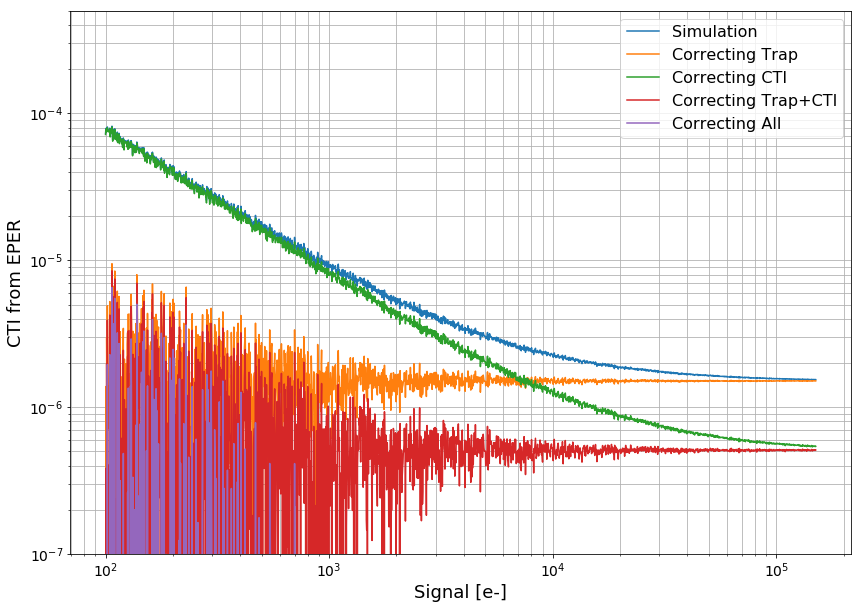

In [61]:
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_sim = ((oscan1+oscan2)/(512*last_pix))

last_pix = corrected1[:, 511]
oscan1 = corrected1[:, 512]
oscan2 = corrected1[:, 513]
cti_corrected1 = ((oscan1+oscan2)/(512*last_pix))

last_pix = corrected2[:, 511]
oscan1 = corrected2[:, 512]
oscan2 = corrected2[:, 513]
cti_corrected2 = ((oscan1+oscan2)/(512*last_pix))

last_pix = corrected3[:, 511]
oscan1 = corrected3[:, 512]
oscan2 = corrected3[:, 513]
cti_corrected3 = ((oscan1+oscan2)/(512*last_pix))

last_pix = corrected4[:, 511]
oscan1 = corrected4[:, 512]
oscan2 = corrected4[:, 513]
cti_corrected4 = ((oscan1+oscan2)/(512*last_pix))
print(cti_corrected4)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signals, cti_sim, label='Simulation')
ax.plot(signals, cti_corrected1, label='Correcting Trap')
ax.plot(signals, cti_corrected2, label='Correcting CTI')
ax.plot(signals, cti_corrected3, label='Correcting Trap+CTI')
ax.plot(signals, cti_corrected4, label='Correcting All')
ax.legend(fontsize=16)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 5.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)
plt.savefig('correction_test.png')

Text(0, 0.5, 'Overscan Signal [e-]')

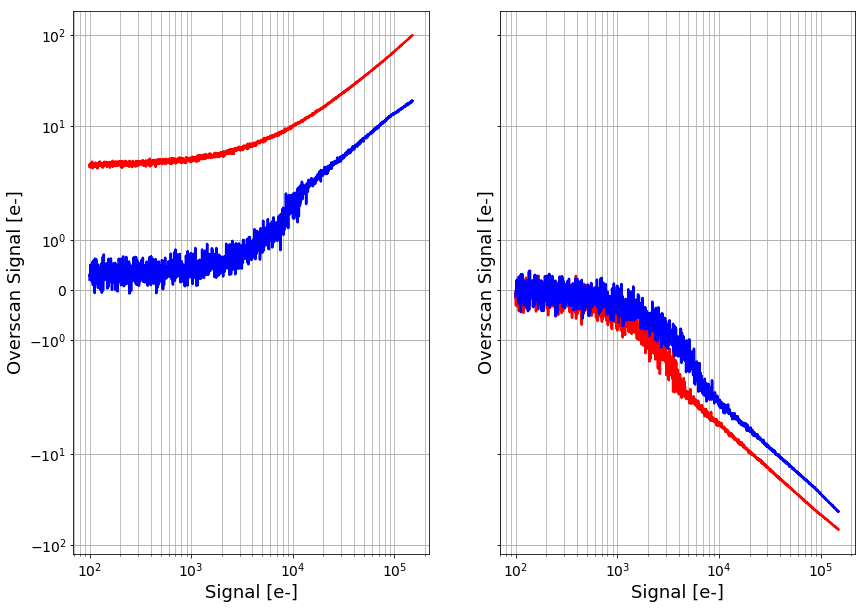

In [62]:
## Data
oscan1_data = segarr[:, 512]
oscan2_data = segarr[:, 513]

## Corrected
oscan1_corrected = corrected4[:, 512]
oscan2_corrected = corrected4[:, 513]

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
    
axes[0].plot(signals, oscan1_data, linewidth=2.5, color='red')
axes[0].plot(signals, oscan2_data, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_yscale('symlog')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(which='both')
axes[0].set_xlabel('Signal [e-]', fontsize=18)
axes[0].set_ylabel('Overscan Signal [e-]', fontsize=18)

axes[1].plot(signals, oscan1_corrected, linewidth=2.5, color='red')
axes[1].plot(signals, oscan2_corrected, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(which='both')
axes[1].set_xlabel('Signal [e-]', fontsize=18)
axes[1].set_ylabel('Overscan Signal [e-]', fontsize=18)

## Testing on Real Data

0.05617523193359375


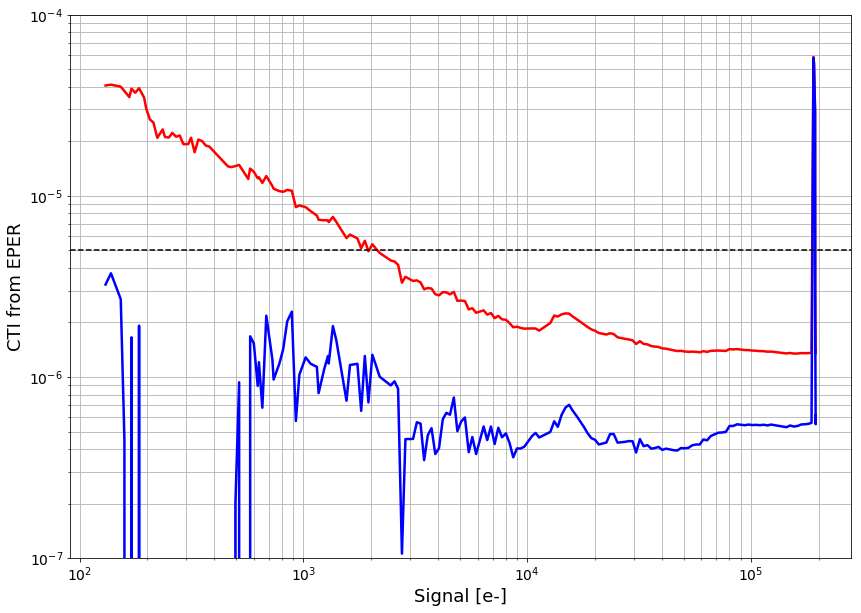

In [6]:
amp = 9

## Get data for comparison
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

data = hdul[amp].data
segarr = data['COLUMN_MEAN']
signals = data['FLATFIELD_SIGNAL']

## Correct with matrix
D_cti = cti_operator(7.390348241862516e-07, nx)
Dinv_cti = inv(D_cti)

corrected = np.zeros(segarr.shape)
#T = one_trap_operator(segarr, 3.461589243866243, 0.018437923800313328)
T = two_trap_operator(segarr, 3.461589243866243, 0.018437923800313328, 
                      2.809391017193702, 12604.767814155908, 0.003718244516148498)
#T = np.zeros(segarr.shape)
S = segarr - (1-cti)*T

start = time.time()
start = time.time()
for i in range(segarr.shape[0]):
    
    corrected[i, :] = Dinv_cti*S[i, :]
    
stop = time.time()
print(stop-start)

## Data
last_pix = data['COLUMN_MEAN'][:, 511]
oscan1 = data['COLUMN_MEAN'][:, 512]
oscan2 = data['COLUMN_MEAN'][:, 513]
cti_data = ((oscan1+oscan2)/(512*last_pix))

## Corrected
last_pix = corrected[:, 511]
oscan1 = corrected[:, 512]
oscan2 = corrected[:, 513]
cti_corrected = ((oscan1+oscan2)/(512*last_pix))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
ax.plot(signals, cti_data, linewidth=2.5, color='red')
ax.plot(signals, cti_corrected, linewidth=2.5, color='blue')
ax.axhline(y=5.E-6, color='black', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)
plt.savefig('correction_test_data.png')

Text(0, 0.5, 'Overscan Signal [e-]')

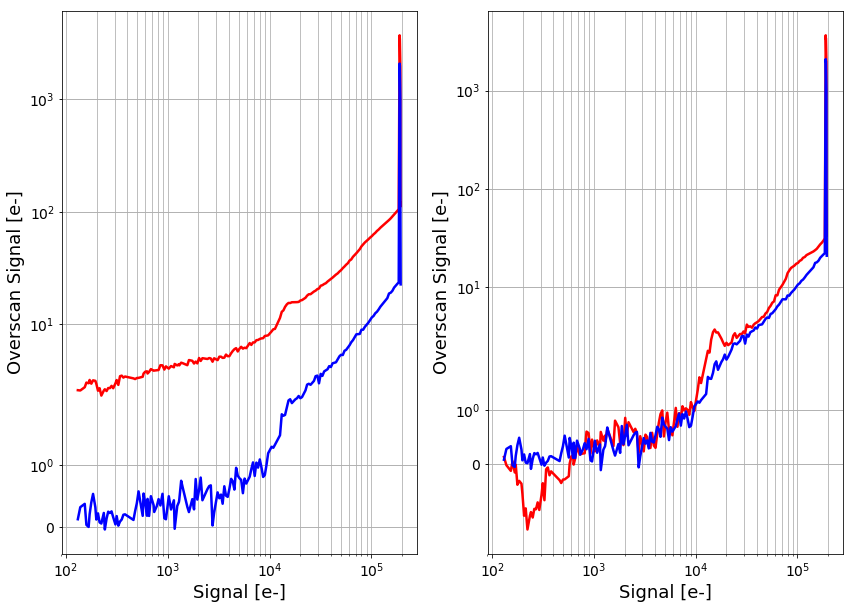

In [15]:
## Data
oscan1_data = data['COLUMN_MEAN'][:, 512]
oscan2_data = data['COLUMN_MEAN'][:, 513]

## Corrected
oscan1_corrected = corrected[:, 512]
oscan2_corrected = corrected[:, 513]

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
    
axes[0].plot(signals, oscan1_data, linewidth=2.5, color='red')
axes[0].plot(signals, oscan2_data, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_yscale('symlog')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(which='both')
axes[0].set_xlabel('Signal [e-]', fontsize=18)
axes[0].set_ylabel('Overscan Signal [e-]', fontsize=18)

axes[1].plot(signals, oscan1_corrected, linewidth=2.5, color='red')
axes[1].plot(signals, oscan2_corrected, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(which='both')
axes[1].set_xlabel('Signal [e-]', fontsize=18)
axes[1].set_ylabel('Overscan Signal [e-]', fontsize=18)

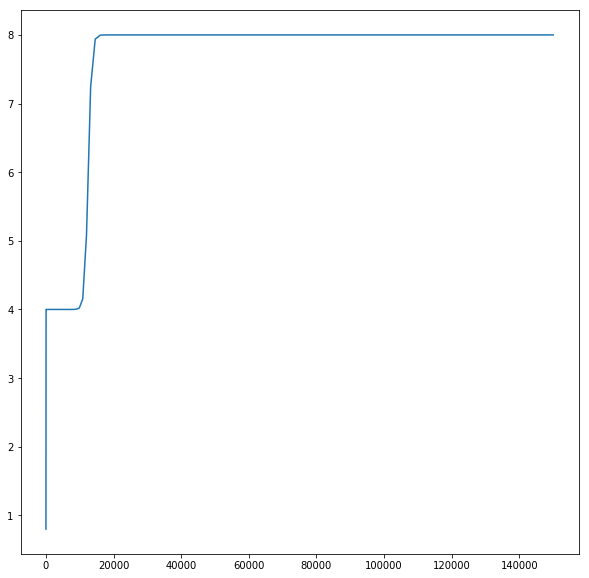

In [8]:
x = np.logspace(1, np.log10(150000.), 100)


y = np.minimum(4.0, 0.08*x) + 4.0/(1.+np.exp(-0.002*(x-12500.)))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x, y)

In [58]:
from scipy.sparse import dia_matrix
A = 0.0002
t = 2.45

ncols = 50

diags = np.asarray([np.ones(ncols)] + [A*np.ones(ncols)*np.exp(-i/t) for i in range(9)])
D = dia_matrix((diags, np.arange(-diags.shape[0]+1, 1)), shape=(ncols, ncols))
print(D)

Dinv = inv(D)
print(np.arange(-diags.shape[0]+1, 1)[::-1])

  (9, 0)	1.0
  (10, 1)	1.0
  (11, 2)	1.0
  (12, 3)	1.0
  (13, 4)	1.0
  (14, 5)	1.0
  (15, 6)	1.0
  (16, 7)	1.0
  (17, 8)	1.0
  (18, 9)	1.0
  (19, 10)	1.0
  (20, 11)	1.0
  (21, 12)	1.0
  (22, 13)	1.0
  (23, 14)	1.0
  (24, 15)	1.0
  (25, 16)	1.0
  (26, 17)	1.0
  (27, 18)	1.0
  (28, 19)	1.0
  (29, 20)	1.0
  (30, 21)	1.0
  (31, 22)	1.0
  (32, 23)	1.0
  (33, 24)	1.0
  :	:
  (25, 25)	7.637048786784323e-06
  (26, 26)	7.637048786784323e-06
  (27, 27)	7.637048786784323e-06
  (28, 28)	7.637048786784323e-06
  (29, 29)	7.637048786784323e-06
  (30, 30)	7.637048786784323e-06
  (31, 31)	7.637048786784323e-06
  (32, 32)	7.637048786784323e-06
  (33, 33)	7.637048786784323e-06
  (34, 34)	7.637048786784323e-06
  (35, 35)	7.637048786784323e-06
  (36, 36)	7.637048786784323e-06
  (37, 37)	7.637048786784323e-06
  (38, 38)	7.637048786784323e-06
  (39, 39)	7.637048786784323e-06
  (40, 40)	7.637048786784323e-06
  (41, 41)	7.637048786784323e-06
  (42, 42)	7.637048786784323e-06
  (43, 43)	7.637048786784323e-06
  (

TypeError: Image data cannot be converted to float

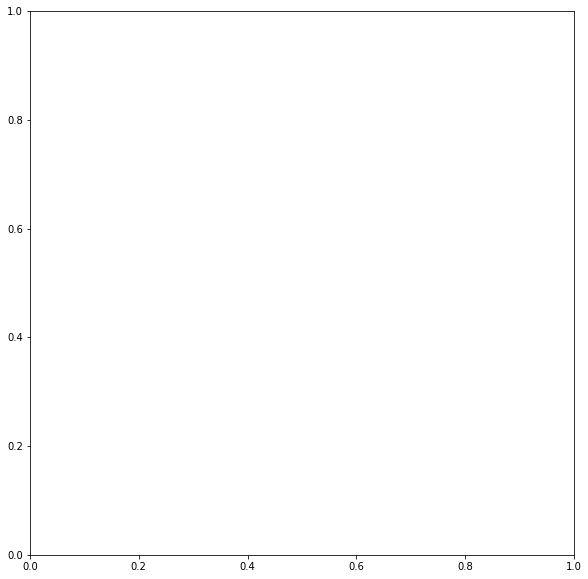

In [47]:
fig, ax =plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(D.toarray)